# Using different Lp-norms for Pauli term truncation

**Note:** If you have not yet read the how-to guide on [truncating Pauli terms](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html) you should do so before reading this guide.

You are already familiar with the truncation of low-weight Pauli terms that is built into the [backpropagate](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.backpropagate.html) method based on a specified [TruncationErrorBudget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.TruncationErrorBudget.html).
In this guide, you will learn about its additional keyword argument `p_norm`, which can be used to change the Lp-norm used to estimate the error incurred by the truncated Pauli terms.

## Constructing an example circuit

For the purposes of this guide, we will use the same example circuit as in the [Pauli term truncation guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html):

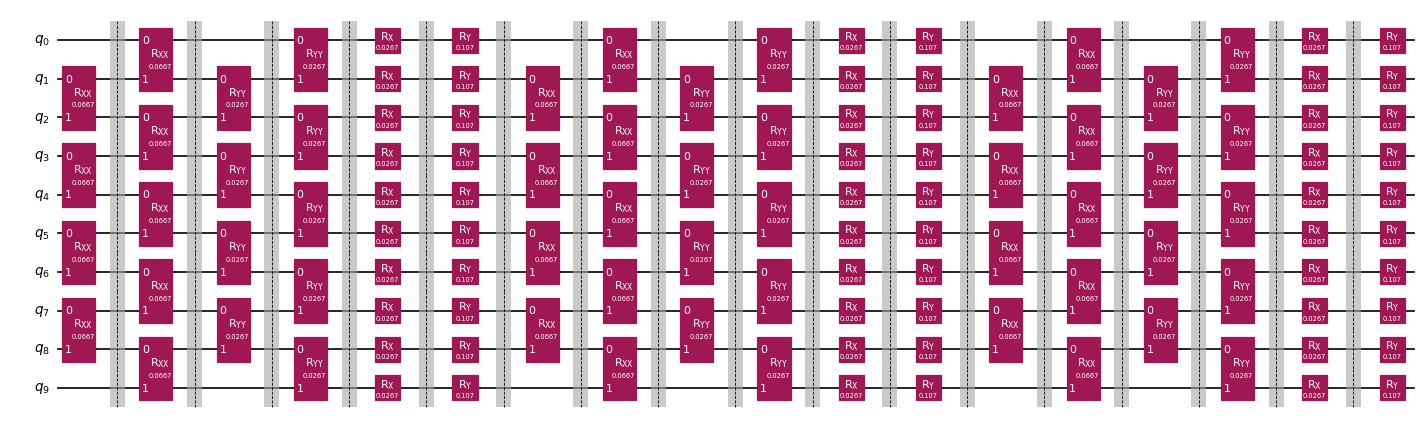

In [1]:
import rustworkx.generators
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import (
    PauliOrderStrategy,
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import combine_slices, slice_by_gate_types

# we generate a linear chain of 10 qubits
num_qubits = 10
linear_chain = rustworkx.generators.path_graph(num_qubits)

# we use an arbitrary XY model
hamiltonian = generate_xyz_hamiltonian(
    linear_chain,
    coupling_constants=(0.05, 0.02, 0.0),
    ext_magnetic_field=(0.02, 0.08, 0.0),
    pauli_order_strategy=PauliOrderStrategy.InteractionThenColor,
)
# we evolve for some time
circuit = generate_time_evolution_circuit(hamiltonian, synthesis=LieTrotter(reps=3), time=2.0)
# slice the circuit by gate type
slices = slice_by_gate_types(circuit)

# for visualization purposes only, we recombine the slices with barriers between them and draw the resulting circuit
combine_slices(slices, include_barriers=True).draw("mpl", fold=50, scale=0.6)

The observable that we will look at is the total magnetization:

In [2]:
from qiskit.quantum_info import SparsePauliOp

obs = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(num_qubits)], num_qubits=num_qubits
)

For reference, we compute the exact expectation value:

In [3]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
job = estimator.run([(circuit, obs)])
res = job.result()
exact_exp = res[0].data.evs
print(exact_exp)

9.318197859862146


## Using the L1 norm

By default, and as you have already seen in the [other how-to guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html), `p_norm=1` which means that the error is estimated as:
$$
|\langle\psi|\Delta|\psi\rangle| \leq \sum_{P\in\mathcal{T}} |c_P|
$$
where $\psi$ is the quantum state, $\Delta$ is the real difference between the exact and truncated observable (which is unknown), $\mathcal{T}$ is the set of Pauli terms that were truncated and $c_P$ is the Pauli terms coefficient.
This inequality is rigorous but a very loose upper bound for most scenarios.

For this simple guide, we will backpropagate 6 slices of our example circuit.
We will use a constant error per slice of `0.001`. This value is to be understood as the budget within the given `p_norm`.

In [4]:
from qiskit_addon_obp.utils.truncating import setup_budget

l1_truncation_error_budget = setup_budget(max_error_per_slice=0.001, p_norm=1)
print(l1_truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.001], max_error_total=inf, p_norm=1)


In [5]:
from qiskit_addon_obp import backpropagate

max_slices = 6
l1_bp_obs, l1_remaining_slices, l1_metadata = backpropagate(
    obs, slices[-max_slices:], truncation_error_budget=l1_truncation_error_budget
)
l1_reduced_circuit = combine_slices(slices[:-max_slices] + l1_remaining_slices)
print(f"Backpropagated {max_slices - len(l1_remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(l1_bp_obs)} terms and {len(l1_bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 6 circuit slices.
New observable contains 116 terms and 10 commuting groups.


We can now compute the expectation value of the backpropagated observable, as well as the error with respect to the exact reference:

In [6]:
estimator = StatevectorEstimator()
job = estimator.run([(l1_reduced_circuit, l1_bp_obs)])
res = job.result()
l1_exp = res[0].data.evs
l1_error = exact_exp - l1_exp
print(l1_exp, l1_error)

9.317869899338842 0.00032796052330397174


Finally, we can plot the error incurred during the backpropagation of each slice, as well as the accumulated error.
The accumulated error is simply the accumulated sum of the slice errors. We can see clearly that the accumulated error is a very loose upper bound to the actual error.

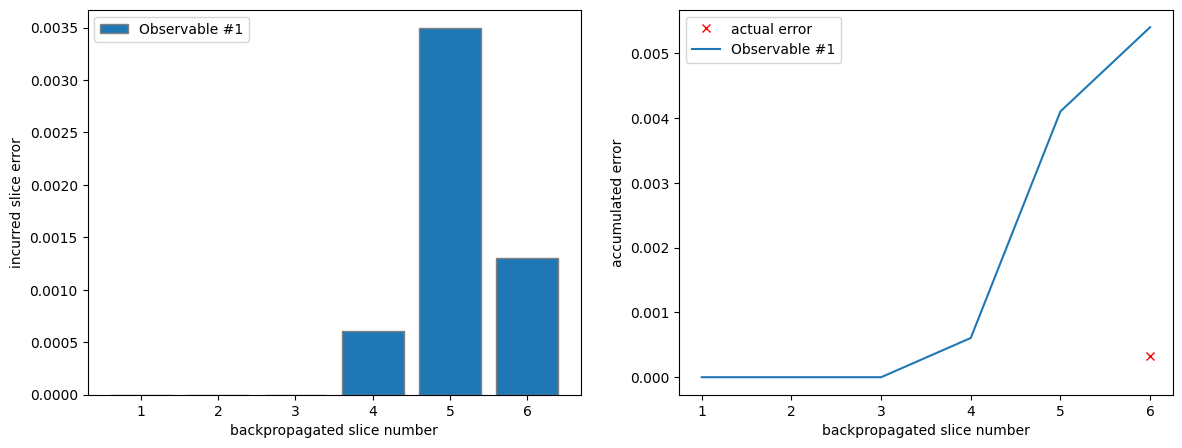

In [7]:
from matplotlib import pyplot as plt
from qiskit_addon_obp.utils.visualization import (
    plot_accumulated_error,
    plot_slice_errors,
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[1].plot([6], [l1_error], "x", color="red", label="actual error")
plot_slice_errors(l1_metadata, axes[0])
plot_accumulated_error(l1_metadata, axes[1])

## Using the L2 norm

One can argue that the L2 norm is a better approximation of the incurred error than the L1 norm.
That is because we can assume the quantum state $|\psi\rangle$ to be drawn from a Haar random ensemble in which case the incurred error follows a distribution with a vanishing mean and a variance that can be approximately bound by the L2 norm:
$$
|\langle\psi|\Delta|\psi\rangle| \lesssim \left( \sum_{P\in\mathcal{T}} |c_P|^2 \right)^{1/2}
$$
While the bound is not rigorous, it will only be violated in pathological cases.

Once again, we will backpropagate 6 slices of our example circuit using a maximum error per slice of `0.001` (this time, interpreted on the L2 norm).

In [8]:
l2_truncation_error_budget = setup_budget(max_error_per_slice=0.001, p_norm=2)
print(l2_truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.001], max_error_total=inf, p_norm=2)


In [9]:
max_slices = 6
l2_bp_obs, l2_remaining_slices, l2_metadata = backpropagate(
    obs, slices[-max_slices:], truncation_error_budget=l2_truncation_error_budget
)
l2_reduced_circuit = combine_slices(slices[:-max_slices] + l2_remaining_slices)
print(f"Backpropagated {max_slices - len(l2_remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(l2_bp_obs)} terms and {len(l2_bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 6 circuit slices.
New observable contains 84 terms and 6 commuting groups.


Once again, we can compute the expectation value of the backpropagated observable, as well as the error with respect to the exact reference:

In [10]:
estimator = StatevectorEstimator()
job = estimator.run([(l2_reduced_circuit, l2_bp_obs)])
res = job.result()
l2_exp = res[0].data.evs
l2_error = exact_exp - l2_exp
print(l2_exp, l2_error)

9.317829770853422 0.00036808900872387085


Plotting the incurred errors per slice and the accumulated error yields a similar picture to before.

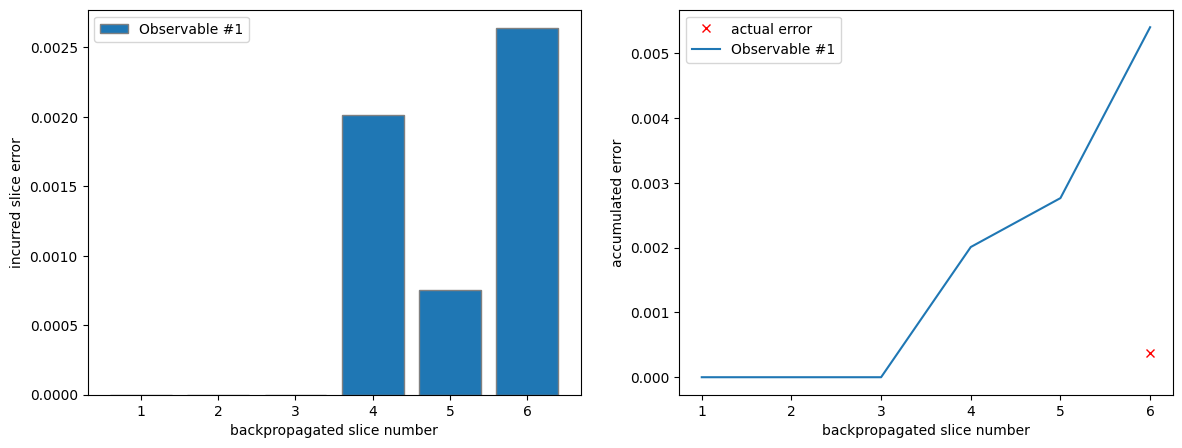

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[1].plot([6], [l2_error], "x", color="red", label="actual error")
plot_slice_errors(l2_metadata, axes[0])
plot_accumulated_error(l2_metadata, axes[1])

Note, that the accumulated error is once again simply the sum of the single slice errors. This is yet another loose bound due to the Minkowski inequality since we have to compute this bound recursively:
$$
|\langle\psi|\Delta_{i}|\psi\rangle| \leq |\langle\psi|\tilde{\Delta}_{i-1}|\psi\rangle| + \left( \sum_{P\in\mathcal{T_i}} |c_P|^2 \right)^{1/2} = |\langle\psi|\tilde{\Delta}_{i}|\psi\rangle|
$$
where the new subscript $i$ indicates the current slice iteration making $\Delta_i$ the actual error at backpropagation iteration $i$, $\tilde{\Delta}_{i-1}$ the approximated truncation error from iteration $i-1$ and $\mathcal{T}_i$ the set of Pauli terms truncated at iteration $i$.